In [1]:
import util
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

# Two batches 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28, 1)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

#batch1 = util.BatchFeeder(X[index[:27000]], Y[index[:27000]], 64)
#batch2 = util.BatchFeeder(X[index[27000:54000]]+np.ones((27000,28,28,1))/2.0, Y[index[27000:54000]], 64)

batch1 = util.BatchFeeder(X[index[:27000]], np.zeros((27000, 1)), 64)
batch2 = util.BatchFeeder(X[index[27000:54000]]/2.0, np.ones((27000, 1)), 64)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


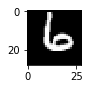

In [11]:
x = batch1.next()[0][0,:,:,0]
plt.figure(figsize=(1,1))
plt.imshow(x, cmap="gray", vmin=0, vmax=1)
plt.show()

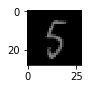

In [16]:
x = batch2.next()[0][0,:,:,0]
plt.figure(figsize=(1,1))
plt.imshow(x, cmap="gray", vmin=0, vmax=1)
plt.show()

# Model with 2 layer CNN

In [5]:
class DeepBatch:
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Parameters
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        if self.built:
            return -1
        else:
            self.built = True
             
        # Placeholders for input
        x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x")
        y = tf.placeholder(tf.float32, shape=[None, 1], name="y")
        
        # Network
        out = self.discriminator(x, reuse=None)
        prediction = tf.nn.sigmoid(out)
            
        # Define cost as the sum of KL and reconstrunction ross with BinaryXent.
        with tf.name_scope("cost"):
            # average over minibatch
            cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=out))
            input_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.square(y-1), logits=out))
        
        # Optimization
        with tf.name_scope("Adam_optimizer"):
            optimizer = tf.train.AdamOptimizer()
            tvars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, tvars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train = optimizer.apply_gradients(clipped, name="minimize_cost")
            
        gs = tf.gradients(ys=input_cost, xs=x)[0]
        gs2 = -1*tf.gradients(ys=cost, xs=x)[0]
        print gs, cost, x
            
        return dict(
            x = x,  
            y = y,
            train = train,
            cost = cost,
            prediction = prediction,
            gs = gs,
            gs2 = gs2
        )
    
    def discriminator(self, _input, reuse=None):
        with tf.variable_scope("discriminator", reuse=reuse):
            # Network
            layer1 = tf.contrib.layers.conv2d(_input, 64, kernel_size=(5,5), activation_fn=tf.nn.relu)
            layer1 = tf.contrib.layers.max_pool2d(layer1, kernel_size=(3,3), stride=(2,2))

            layer2 = tf.contrib.layers.conv2d(layer1, 128, kernel_size=(5,5), activation_fn=tf.nn.relu)
            layer2 = tf.contrib.layers.max_pool2d(layer2, kernel_size=(3,3), stride=(2,2))

            dense = tf.contrib.layers.flatten(layer2)
            out = tf.contrib.layers.fully_connected(dense, 1, activation_fn=tf.identity)
        return out
    
    # Closing session
    def close(self):
        self.sesh.close()
    
    # training procedure.
    def train(self, X1, X2, epochs):
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X1.n*1.0/X1.batch_size))
        
        e = 0
        start_e = self.e
        while e < epochs:
            
            for i in range(batch_num):
                #Training happens here.
                batch1 = X1.next()
                batch2 = X2.next()
                feed_dict = {self.ops["x"]: np.concatenate([batch1[0], batch2[0]], axis=0),
                             self.ops["y"]: np.concatenate([batch1[1], batch2[1]], axis=0)}
                ops_to_run = [self.ops["cost"],
                              self.ops["prediction"],
                              self.ops["gs"],
                              self.ops["gs2"],
                              self.ops["train"]]
                cost, pred, gs, gs2, _= self.sesh.run(ops_to_run, feed_dict)
                
                if e%5 == 0:
                    
                
                #Print progress
                sys.stdout.write("\rEpoch: [%2d/%2d] Batch: [%2d/%2d] loss: %.2f"%(self.e, start_e+epochs, i, batch_num, cost))
            self.e+=1
            e+= 1
        return gs, gs2, pred, np.concatenate([batch1[0], batch2[0]], axis=0)
            
    def save(self, folder):
        saver = tf.train.Saver(tf.all_variables())
        os.system("mkdir "+folder)
        saver.save(self.sesh, folder+"/model.ckpt")
        
    def load(self, folder):
        saver = tf.train.Saver(tf.all_variables())
        saver.restore(self.sesh, folder+"/model.ckpt")

In [6]:
model = DeepBatch()

Tensor("gradients/discriminator/Conv/Conv2D_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("cost/Mean:0", shape=(), dtype=float32) Tensor("x:0", shape=(?, 28, 28, 1), dtype=float32)


In [7]:
out = model.train(batch1, batch2, 1)

Epoch: [ 0/ 1] Batch: [421/422] loss: 0.00

batch1: 61


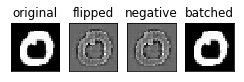

batch2: 65


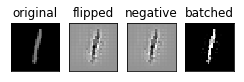

In [66]:
index = np.random.randint(64)
multiplier = 100
print "batch1:", index

plt.figure(figsize=(4,1))
plt.subplot(141)
plt.imshow(out[3][index, :, :, 0], cmap="gray", vmin=0, vmax=1)
plt.yticks([],[])
plt.xticks([],[])
plt.title("original")
plt.subplot(142)
plt.imshow(out[0][index, :, :, 0], cmap="gray")
plt.yticks([],[])
plt.xticks([],[])
plt.title("flipped")
plt.subplot(143)
plt.imshow(out[1][index, :, :, 0], cmap="gray")
plt.yticks([],[])
plt.xticks([],[])
plt.title("negative")
plt.subplot(144)
plt.imshow(out[3][index, :, :, 0], cmap="gray", vmin=0, vmax=1)
plt.yticks([],[])
plt.xticks([],[])
plt.title("batched")
plt.show()

index = np.random.randint(64)+64
print "batch2:", index

plt.figure(figsize=(4,1))
plt.subplot(141)
plt.imshow(out[3][index, :, :, 0], cmap="gray", vmin=0, vmax=1)
plt.yticks([],[])
plt.xticks([],[])
plt.title("original")
plt.subplot(142)
plt.imshow(out[0][index, :, :, 0], cmap="gray")
plt.yticks([],[])
plt.xticks([],[])
plt.title("flipped")
plt.subplot(143)
plt.imshow(out[1][index, :, :, 0], cmap="gray")
plt.yticks([],[])
plt.xticks([],[])
plt.title("negative")
plt.subplot(144)
plt.imshow(out[3][index, :, :, 0]-out[0][index, :, :, 0]*multiplier, cmap="gray", vmin=0, vmax=1)
plt.yticks([],[])
plt.xticks([],[])
plt.title("batched")
plt.show()